## Importation des librairies

In [2]:
import spacy, stanza
import pandas as pd
import langid
import seaborn as sns
import matplotlib.pyplot as plt
import jupyter_black
from collections import defaultdict

In [3]:
jupyter_black.load()

## Chargement des données

In [4]:
# Load data
data = pd.read_csv("../../data/csv/data.csv")

## Tokenization

In [5]:
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

nlp_ar = stanza.Pipeline(lang="ar")  # Arabic

2024-05-10 08:46:20 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-10 08:46:20 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
INFO:stanza:Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-10 08:46:21 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-10 08:46:21 INFO: Using device: cpu
INFO:stanza:Using device: cpu
2024-05-10 08:46:21 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2024-05-10 08:46:22 INFO: Loading: mwt
INFO:stanza:Loading: mwt
20

In [6]:
def tokenize(text: str, lang: str) -> list:
    """
    Permet de tokeniser un texte en fonction de la langue

    Parameters:
    text (str): le texte à tokeniser
    lang (str): la langue du texte

    Returns:
    list: une liste de tokens
    """
    if lang == "ar":
        doc = nlp_ar(text)
        return [word.text for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [token.text for token in doc]

**Tokenisation** : 
- Chaque document est tokenisé selon la langue à l'aide des modèles de NLP correspondants. Les tokens sont les mots dans le cas des langues occidentales et des unités plus complexes pour des langues comme le chinois ou le japonais.

## Statistiques descriptives des données

Statistiques descriptives utilisé également pour l'analyse du corpus de référence. [Lien vers l'article](https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad)

In [16]:
def get_stats(data: pd.DataFrame) -> pd.DataFrame:
    """
    Permet de calculer des statistiques sur les données

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    pd.DataFrame: les statistiques calculées
        n_lang: le nombre de langues
        n_text: le nombre de textes
        n_text_per_lang: le nombre de textes par langue
        mean_tokens_per_text: le nombre moyen de tokens par texte
        n_text_under_100_chars: le nombre de textes de moins de 100 caractères par langue
        ratio_text_under_100_tokens: le ratio de textes de moins de 100 tokens par langue
    """
    languages = defaultdict()
    tokens = defaultdict()
    for i, row in data.iterrows():
        lang = row["Label"]
        text = row["Text"]
        if lang not in languages:
            languages[lang] = 0
            tokens[lang] = 0
        languages[lang] += 1
        tokens[lang] += len(tokenize(text, lang))

    # Initialisation du dictionnaire pour les statistiques
    stats = defaultdict()

    # Calcul du nombre total de langues
    stats["n_lang"] = len(languages)

    # Calcul du nombre total de textes
    stats["n_text"] = sum(languages.values())

    # Nombre de textes par langue
    stats["n_text_per_lang"] = {}
    for lang in languages:
        stats["n_text_per_lang"][lang] = languages[lang]

    # Nombre moyen de tokens par texte pour chaque langue
    stats["mean_tokens_per_text"] = {}
    for lang in languages:
        stats["mean_tokens_per_text"][lang] = tokens[lang] / languages[lang]

    # Nombre de textes de moins de 100 caractères par langue
    stats["n_text_under_100_tokens"] = {}
    for lang in languages:
        # Initialiser à 0 pour chaque langue
        stats["n_text_under_100_tokens"][lang] = 0
        # Parcourir les données et accumuler le nombre de textes courts
        for i, row in data[data["Label"] == lang].iterrows():
            if len(row["Text"]) < 100:
                stats["n_text_under_100_tokens"][lang] += 1

    # Ratio de textes de moins de 100 tokens par langue
    stats["ratio_text_under_100_tokens"] = {}
    for lang in languages:
        # Calculer le nombre total de textes courts en tokens pour chaque langue
        short_texts = 0
        for i, row in data[data["Label"] == lang].iterrows():
            if len(tokenize(row["Text"], lang)) < 100:
                short_texts += 1
        # Calculer le ratio pour chaque langue
        stats["ratio_text_under_100_tokens"][lang] = (
            short_texts / languages[lang] if languages[lang] > 0 else 0
        )

    df_stats = pd.DataFrame(
        {
            "n_text_per_lang": stats["n_text_per_lang"],
            "mean_tokens_per_text": stats["mean_tokens_per_text"],
            "n_text_under_100_tokens": stats["n_text_under_100_tokens"],
            "ratio_text_under_100_tokens": stats["ratio_text_under_100_tokens"],
        }
    )

    df_stats["n_lang"] = stats["n_lang"]
    df_stats["n_text"] = stats["n_text"]

    # Ajout d'une ligne globale
    global_row = {
        "n_text_per_lang": sum(stats["n_text_per_lang"].values()),
        "mean_tokens_per_text": sum(tokens.values()) / stats["n_text"],
        "n_text_under_100_tokens": sum(stats["n_text_under_100_tokens"].values()),
        "ratio_text_under_100_tokens": sum(stats["n_text_under_100_tokens"].values())
        / stats["n_text"],
        "n_lang": stats["n_lang"],
        "n_text": stats["n_text"],
    }

    df_stats.loc["Global"] = global_row

    df_stats = df_stats.reset_index().rename(columns={"index": "lang"})

    return df_stats

In [17]:
df = get_stats(data)
print(df)

# global_stat = get_global_stats(data)
# print(global_stat)

# save the stats
df.to_csv("../../resultats/stats_corpus.csv", index=False)

     lang  n_text_per_lang  mean_tokens_per_text  n_text_under_100_tokens  \
0      ar              548            118.864964                       45   
1      en              550             50.350909                       19   
2      zh              550             46.169091                      396   
3      de              550             28.905455                      103   
4      ko              550             29.196364                      303   
5      es              550             48.825455                       31   
6      ja              550             59.263636                      298   
7      ru              550             34.460000                       74   
8      fr              550             48.876364                       25   
9  Global             4948             51.629749                     1294   

   ratio_text_under_100_tokens  n_lang  n_text  
0                     0.545620       9    4948  
1                     0.972727       9    4948  
2    

In [18]:
def calculate_metrics(data: pd.DataFrame) -> dict:
    """
    Calcule les métriques de diversité lexicale pour chaque langue ainsi que la moyenne globale de tokens par texte

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    dict: un dictionnaire contenant les métriques
        Average Words per Sample (float): le nombre moyen de tokens par texte
        Lexical Diversity (float): la diversité lexicale
    """

    language_data = defaultdict(list)

    for index, row in data.iterrows():
        tokens = tokenize(row["Text"], row["Label"])
        language_data[row["Label"]].append(tokens)

    results = {}

    for lang, tokens_list in language_data.items():
        total_words = sum(len(tokens) for tokens in tokens_list)
        total_samples = len(tokens_list)
        unique_words = len(set(word for tokens in tokens_list for word in tokens))

        average_words_per_sample = total_words / total_samples if total_samples else 0
        lexical_diversity = unique_words / total_words if total_words else 0

        results[lang] = {
            "Average Words per Sample": average_words_per_sample,
            "Lexical Diversity": lexical_diversity,
        }
        results = pd.DataFrame(results)

    return results

**Métriques calculées** :
- **Moyenne des mots par échantillon** : Cela donne une idée de la longueur moyenne des textes pour chaque langue.
- **Diversité lexicale** : C'est le rapport entre le nombre de mots uniques et le nombre total de mots dans les échantillons de chaque langue. Une valeur plus élevée indique une plus grande richesse lexicale.

In [24]:
# Compute metrics
metrics = calculate_metrics(data)

# Display the metrics
print(metrics)

# save the metrics
metrics.to_csv("../../resultats/metrics_corpus.csv")

                                  ar         en         zh         de  \
Average Words per Sample  118.864964  50.350909  46.169091  28.905455   
Lexical Diversity           0.212196   0.253494   0.332533   0.352875   

                                 ko         es         ja         ru  \
Average Words per Sample  29.196364  48.825455  59.263636  34.460000   
Lexical Diversity          0.532694   0.263015   0.196687   0.418614   

                                 fr  
Average Words per Sample  48.876364  
Lexical Diversity          0.250019  


**Affichage des Résultats** : 
- Les résultats sont stockés dans un dictionnaire et imprimés.

1. **Arabe (ar)** : Le nombre élevé de mots par échantillon (118.86) pour l'arabe, même dans le cadre de deux phrases maximum, souligne la tendance à utiliser des phrases plus longues et complexes en arabe. La faible diversité lexicale (0.212) indique cependant que même ces phrases longues et complexes peuvent se répéter ou utiliser un nombre limité de mots uniques.

2. **Anglais (en)** : Une moyenne de 50.35 mots par échantillon avec une diversité lexicale de 0.253 dans des textes courts indique une bonne balance entre longueur et variété. Cela reflète l'efficacité de l'anglais à transmettre l'information de manière concise tout en maintenant une diversité linguistique modérée.

3. **Chinois (zh)** : Le chinois montre une capacité à inclure une diversité de vocabulaire (0.333) assez élevée dans des textes de longueur modérée (46.17 mots), ce qui pourrait refléter l'utilisation de nombreux caractères uniques, même dans des communications brèves.

4. **Allemand (de)** : L'allemand, avec une moyenne de 28.91 mots et une diversité lexicale de 0.353, montre que même dans des textes courts, la langue peut utiliser une variété de structures et de lexique, probablement en raison de la capacité de formation de mots composés en allemand.

5. **Coréen (ko)** : Une diversité lexicale élevée (0.533) avec seulement 29.20 mots par échantillon suggère une grande richesse de vocabulaire dans de courtes phrases. Cela pourrait indiquer une utilisation efficace de mots uniques et des formes honorifiques distinctes en coréen.

6. **Espagnol (es)** : Avec un nombre moyen de mots (48.83) et une diversité lexicale (0.263) modérées, l'espagnol semble équilibrer entre la clarté et la richesse descriptive dans des formats de texte courts.

7. **Japonais (ja)** : Le japonais utilise de manière répétitive son vocabulaire (0.197 de diversité lexicale) dans des textes relativement longs (59.26 mots), ce qui pourrait refléter l'usage fréquent de formules fixes ou de particules grammaticales.

8. **Russe (ru)** : Avec un nombre moyen de mots de 34.46 et une diversité lexicale de 0.419, le russe montre une utilisation variée du vocabulaire dans des textes qui, bien que courts, peuvent inclure des structures complexes et inflexions.

9. **Français (fr)** : Le français montre une utilisation modérée de vocabulaire (0.250 de diversité lexicale) dans des textes de longueur modérée (48.88 mots), ce qui pourrait indiquer une préférence pour des phrases bien construites et nuancées même dans des limites de deux phrases.

## Loi de Zipf

In [23]:
def loi_zipf_par_lang(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule la loi de Zipf pour chaque langue.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    pd.DataFrame: un DataFrame contenant les résultats.
    """
    results = defaultdict(list)

    for text, lang in zip(data["Text"], data["Label"]):
        lang = langid.classify(text)[0] if lang == "unknown" else lang
        tokens = tokenize(text, lang)
        freq = pd.Series(tokens).value_counts()
        freq = freq.reset_index()
        freq.columns = ["Token", "Frequency"]
        freq["Rank"] = freq["Frequency"].rank(ascending=False)
        freq["Language"] = lang
        results[lang].append(freq)

    dfs = []
    for lang, lang_freqs in results.items():
        lang_freqs_df = pd.concat(lang_freqs)
        lang_freqs_df["Frequency"] = (
            lang_freqs_df["Frequency"] / lang_freqs_df["Frequency"].sum()
        )
        dfs.append(lang_freqs_df)

    final_df = pd.concat(dfs)
    final_df = final_df[["Token", "Frequency", "Rank", "Language"]]
    return final_df


zipf_results = loi_zipf_par_lang(data)
print(zipf_results)

             Token  Frequency  Rank Language
0                ل   0.000046   1.0       ar
1                ،   0.000031   2.5       ar
2            تعداد   0.000031   2.5       ar
3           الحمرة   0.000015  17.0       ar
4          مديريات   0.000015  17.0       ar
..             ...        ...   ...      ...
41      techniques   0.000037  27.5       fr
42  discrimination   0.000037  27.5       fr
43           forme   0.000037  27.5       fr
44            peut   0.000037  27.5       fr
45         glaçage   0.000037  27.5       fr

[189663 rows x 4 columns]


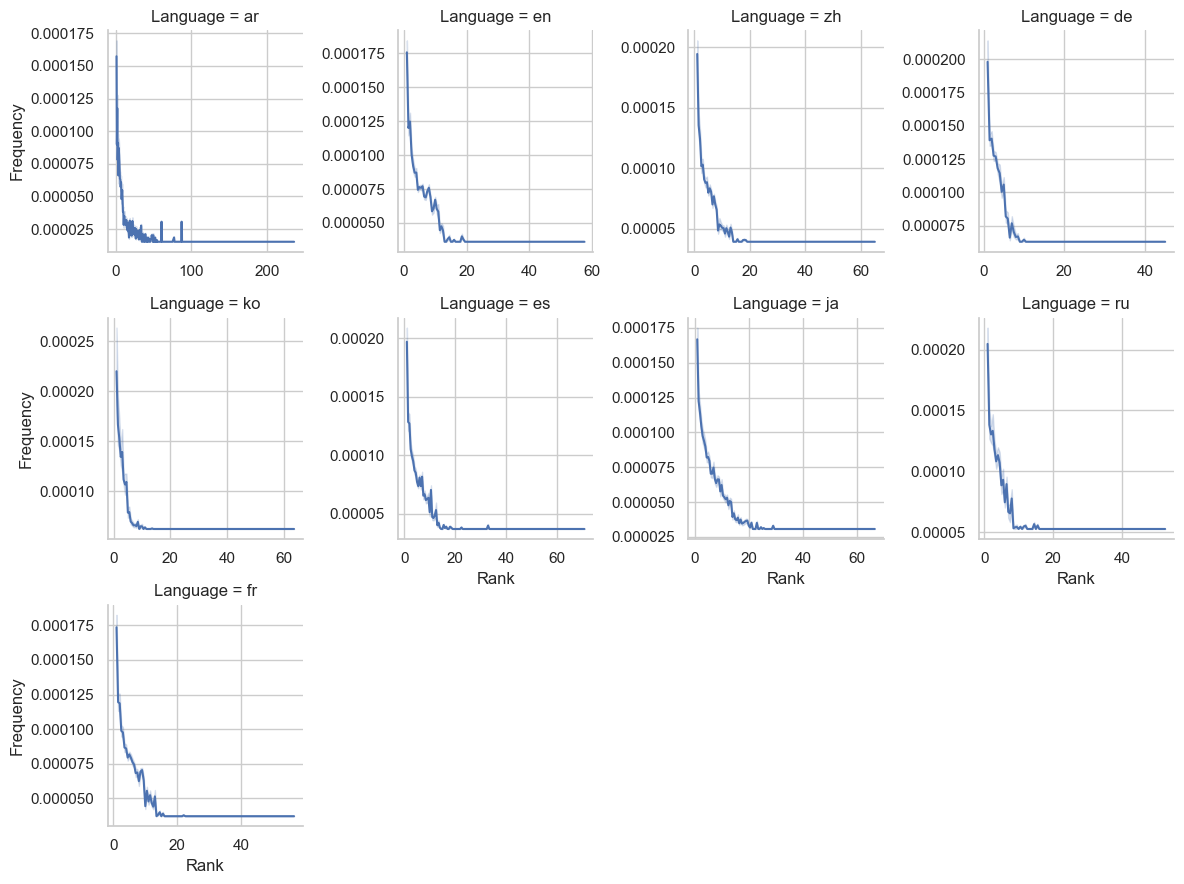

In [22]:
def plot_zipf(data: pd.DataFrame) -> plt.Figure:
    """
    Crée un graphique de la loi de Zipf pour chaque langue.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    plt.Figure: l'objet Figure contenant le graphique
    """
    sns.set(style="whitegrid")
    g = sns.FacetGrid(data, col="Language", col_wrap=4, sharex=False, sharey=False)
    g.map(sns.lineplot, "Rank", "Frequency")

    return g.fig


zipf = plot_zipf(zipf_results)
zipf.savefig("../../resultats/zipf.png", facecolor="white", dpi=300)

1. **`loi_zipf_par_lang(data: pd.DataFrame) -> pd.DataFrame`**:
   Cette fonction calcule la loi de Zipf pour chaque langue dans un DataFrame donné. 

   Voici ce qu'elle fait :
   - Prend en entrée un DataFrame `data` contenant des colonnes "Text" (texte à analyser) et "Label" (langue du texte).
   - Initialise un dictionnaire `results` par défaut, qui va stocker les résultats de la loi de Zipf pour chaque langue.
   - Parcourt chaque texte et sa langue correspondante dans le DataFrame. Si la langue est "unknown", elle est détectée à l'aide de `langid.classify(text)`.
   - Tokenise le texte en utilisant la fonction `tokenize(text, lang)`.
   - Compte la fréquence des tokens à l'aide de `pd.Series(tokens).value_counts()` et les classe par ordre décroissant.
   - Normalise les fréquences en divisant par la somme des fréquences.
   - Stocke les résultats dans le dictionnaire `results`.
   - Concatène tous les DataFrames de résultats pour chaque langue dans une seule DataFrame et la retourne.

2. **`plot_zipf(data: pd.DataFrame) -> None`**:
   Cette fonction trace la loi de Zipf pour chaque langue dans un DataFrame donné. 
   
   Voici ce qu'elle fait :
   - Prend en entrée un DataFrame `data` contenant les résultats de la loi de Zipf pour chaque langue.
   - Crée une grille de facettes (`FacetGrid`) de seaborn avec une colonne pour chaque langue, en utilisant `sns.FacetGrid`.
   - Pour chaque langue, trace un graphique de ligne montrant la relation entre le rang et la fréquence à l'aide de `sns.lineplot`.
   - Retourne le tracé à l'aide de `return g.fig`.

En résumé, la première fonction calcule les statistiques de la loi de Zipf pour chaque langue dans les données, tandis que la deuxième fonction trace ces statistiques pour chaque langue.

Interprétation des résultats :
Les sous-graphiques, intitulés selon leurs langues respectives, affichent des schémas similaires :

1. **Schéma décroissant :** Tous les graphiques montrent une diminution rapide de la fréquence des mots à mesure que le rang augmente. Cela est conforme à la loi de Zipf, qui stipule que la fréquence d'un mot est inversement proportionnelle à son rang dans le tableau des fréquences. En d'autres termes, les mots les plus utilisés ont une fréquence élevée, qui diminue rapidement pour les mots moins utilisés.

2. **Différentes échelles :** Bien que les schémas soient similaires, les échelles des axes diffèrent d'une langue à l'autre. Par exemple, la fréquence maximale varie d'une langue à l'autre, ce qui indique des différences dans la distribution de l'utilisation des mots.

3. **Longue traîne :** La plupart des graphiques présentent une longue traîne, indiquant que de nombreux mots sont utilisés avec une fréquence relativement faible. Ceci est typique pour les langues naturelles, où un petit nombre de mots est très fréquemment utilisé, tandis que la plupart des mots sont utilisés de manière peu fréquente.
